In [1]:
!pwd

/home/ubuntu/Notebook


In [2]:
!ls

diabetic-model.ipynb


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import pandas as pd
import numpy as np
# from medpy.io import load
from matplotlib import pyplot as plt
import glob
import cv2

import sklearn.metrics as sklm

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model

import scipy
import matplotlib.image as mpimg
from scipy.misc import imread

%matplotlib inline

Using TensorFlow backend.


In [15]:
rootDir = "/home/ubuntu/Yang_Sahana/train"
Use_Model = "ResNet" #"ResNet" or "VGGNet"
image_size = 512

In [11]:
resize_128_dir = "/home/ubuntu/final_data/train/128"
# Create directory for 128x128 resize
try:
    os.stat(resize_128_dir)
except:
    os.makedirs(resize_128_dir)
    
resize_256_dir = "/home/ubuntu/final_data/train/256"
# Create directory for 256x256 resize
try:
    os.stat(resize_256_dir)
except:
    os.makedirs(resize_256_dir)

resize_512_dir = "/home/ubuntu/final_data/train/512"
# Create directory for 512x512 resize
try:
    os.stat(resize_512_dir)
except:
    os.makedirs(resize_512_dir)

In [12]:
# read the labels
labels = pd.read_csv('/home/ubuntu/trainLabels.csv')
labels.head(10)

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
5,15_right,2
6,16_left,4
7,16_right,4
8,17_left,0
9,17_right,1


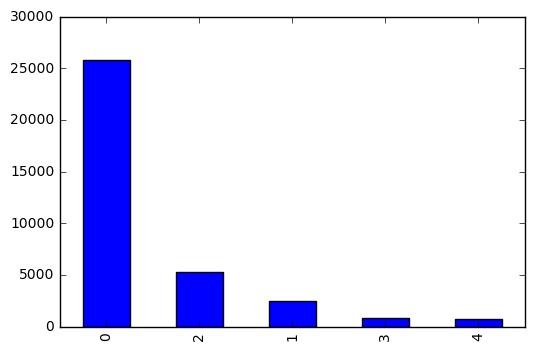

In [13]:
# class imbalance
labels['level'].value_counts().plot(kind='bar')

# Notes:
# 5 labels present - 0 to 4

In [16]:
x_train_list = []
y_train_list = []
x_val_list = []
y_val_list = []

train_percent = 0.6 # 60% train
if image_size == 128:
    Image_File_Path = resize_128_dir
elif image_size == 256:
    Image_File_Path = resize_256_dir
else:
    Image_File_Path = resize_512_dir
        
for index, row in labels.iterrows():
    try:
        img_data = np.fromfile(Image_File_Path + '/' + row['image'] + '.data', dtype='uint8', sep="")
    except:
        continue

    img_data = img_data.reshape([image_size, image_size, 3])
    
    rand_no = np.random.rand()
    if rand_no <= train_percent:
        x_list = x_train_list
        y_list = y_train_list
    else:
        x_list = x_val_list
        y_list = y_val_list
        
    if row['level'] == 0:
        y_list.append([1, 0, 0, 0, 0])
    elif row['level'] == 1:
        y_list.append([0, 1, 0, 0, 0])
    elif row['level'] == 2:
        y_list.append([0, 0, 1, 0, 0])
    elif row['level'] == 3:
        y_list.append([0, 0, 0, 1, 0])
    elif row['level'] == 4:
        y_list.append([0, 0, 0, 0, 1])
    else:
        continue
    
    x_list.append(img_data)

x_train = np.array(x_train_list)
y_train = np.array(y_train_list)
print x_train.shape
print y_train.shape

x_val = np.array(x_val_list)
y_val = np.array(y_val_list)
print x_val.shape
print y_val.shape



/home/ubuntu/final_data/train/512
(1720, 512, 512, 3)
(1720, 5)
(1073, 512, 512, 3)
(1073, 5)


In [17]:
# Function for VGGNet
def VGGNet_model(input_shape, num_classes, use_sgd=False):
    model_vgg19_conv = VGG19(weights='imagenet', include_top=False)
    model_vgg19_conv.summary()
    
#    for layer in model_vgg16_conv.layers:
#        layer.trainable = False

    # Create your own input format
    input = Input(shape=input_shape, name = 'image_input')
    
    # Use the generated model 
    output_vgg19_conv = model_vgg19_conv(input)
  
    
    # Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg19_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(1000, activation='relu', name='fc3')(x)

    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Create model 
    AD_model = Model(input=input, output=x)
    AD_model.summary()

    # Compile model
    if not use_sgd:
        AD_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print "using adam optimizer"
    else:
        sgd = SGD(lr=0.01, momentum=0.8, decay=0.000001, nesterov=False)
        AD_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[ 'accuracy' ])
        print "using SGD optimizer"
    
    return AD_model

In [18]:
# Function for resnet
def ResNet_model(input_shape, num_classes, use_sgd=False):
    model_resnet_conv = ResNet50(weights='imagenet', include_top=False)
    
#    for layer in model_vgg16_conv.layers:
#        layer.trainable = False

    # Create your own input format
    input = Input(shape=input_shape, name = 'image_input')
    
    # Use the generated model 
    output_resnet_conv = model_resnet_conv(input)
    
    # Add the fully-connected layers 
    x = Flatten(name='flatten')(output_resnet_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)

    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    # Create model 
    AD_model = Model(input=input, output=x)
    AD_model.summary()

    # Compile model
    if not use_sgd:
        AD_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        print "using adam optimizer"
    else:
        sgd = SGD(lr=0.01, momentum=0.8, decay=0.000001, nesterov=False)
        AD_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=[ 'accuracy' ])
        print "using SGD optimizer"
    
    return AD_model

In [19]:
if Use_Model == "ResNet":
    print "Using ResNet"
    my_model = ResNet_model((image_size,image_size,3), 5, use_sgd=True)
else:
    print "Using VGGNet"
    my_model= VGGNet_model((image_size,image_size,3), 5, use_sgd=True)
my_model.summary()

Using ResNet


/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("im...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 512, 512, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              33558528  
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 5)                 20485     
Total params: 73,948,037
Trainable params: 73,894,917
Non-trainable params: 53,120
___________________________________________________________

In [ ]:
# Fit the model
my_model.fit(x_train, y_train, epochs=1, batch_size=50, validation_data=(x_val, y_val), verbose=1)

Train on 1720 samples, validate on 1073 samples
Epoch 1/1


In [ ]:
# Final evaluation of the model
#scores = my_model.evaluate(x_test, y_test, verbose=0)
#print("CNN Error: %.2f%%" % (100-scores[1]*100))